In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

A = np.array([[0.9512, 0],
              [0.0476, 0.9512]], ndmin = 2)
B = np.array([[0.0975], [0.0024]], ndmin = 2)
C = np.array([0, 1], ndmin = 2)

mean_w = np.array([0, 0])
Q = 1e-3 * np.array([[9.506, 0.234],
                     [0.234, 9.512]], ndmin = 2)
mean_v = 0
R = 0.0125

mu_0 = np.array([5, 5])
P_0 = np.array([[1, 0],
                [0, 1]], ndmin = 2)

u = np.loadtxt("./Data_nonlinear_case/input_nonlinear_case.txt", skiprows = 1, usecols = 0)
y = np.loadtxt("./Data_nonlinear_case/Measured_output_nonlinear_case.txt", skiprows = 1, usecols = 0)
true_x1 = np.loadtxt("./Data_nonlinear_case/True_state_x1_nonlinear_case.txt", skiprows = 1, usecols = 0)
true_x2 = np.loadtxt("./Data_nonlinear_case/True_state_x2_nonlinear_case.txt", skiprows = 1, usecols = 0)

assert len(u) == len(y) == len(true_x1) == len(true_x2)

number_step_max = len(u)

h = 0.1 # sampling period in second
time = np.arange(len(true_x1)) * h #time in seconds


In [7]:
def f_x(x,u):
    
    lol = np.array([[-np.sqrt(x[:, 0, 0]) + u], [np.sqrt(x[:, 0, 0]) - np.sqrt(x[:, 1, 0])]], ndmin=2)
    lol = np.transpose(lol, (2, 0, 1))
    return lol
    


In [8]:
def forecast_step(h, ens_x_k_1, B, u_k, mean_w, Q):
    ensemble_size = len(ens_x_k_1)
    wk = np.random.multivariate_normal(mean_w, Q, size = ensemble_size)
    wk = np.reshape(wk, (ensemble_size, 2, 1))
    f1 = f_x(ens_x_k_1, u_k)
    f2 = f_x(ens_x_k_1 + h * f1 / 2, u_k)
    f3 = f_x(ens_x_k_1 + h * f2 / 2, u_k)
    f4 = f_x(ens_x_k_1 + h * f3, u_k)
    ens_x_tilde_k = ens_x_k_1 + h / 6 * (f1 + 2 * f2 + 2 * f3 + f4) + wk
    return ens_x_tilde_k

def make_observations_step(C, ens_x_tilde_k, mean_v, R):
    ensemble_size = len(ens_x_tilde_k)
    vk = np.random.normal(mean_v, R, size = ensemble_size)
    vk = np.reshape(vk, (ensemble_size, 1, 1))
    ens_y_tilde_k = C@ens_x_tilde_k + vk
    return ens_y_tilde_k

def update_step(C, ens_x_tilde_k, R, yk, ens_y_tilde_k):
    P_tilde_hat_k = np.cov(np.squeeze(ens_x_tilde_k), rowvar = False)
    K_tilde_k = P_tilde_hat_k@C.T@np.linalg.inv(C@P_tilde_hat_k@C.T + R)
    ens_x_hat_k = ens_x_tilde_k + K_tilde_k@(yk - ens_y_tilde_k)
    return ens_x_hat_k

In [9]:
mu = pd.DataFrame(columns = ["mu_x1", "mu_x2"])
P = pd.DataFrame(columns = ["x1x1", "x1x2", "x2x1", "x2x2"])

ensemble_size = 10
ens_x_hat_k_1 = np.random.multivariate_normal(mu_0, P_0, size = ensemble_size)
ens_x_hat_k_1 = np.reshape(ens_x_hat_k_1, (ensemble_size, 2, 1))
#print(ens_x_hat_k_1.shape)

for i in range(number_step_max):
    ens_x_tilde_k = forecast_step(h, ens_x_hat_k_1, B, u[i], mean_w, Q)
    ens_y_tilde_k = make_observations_step(C, ens_x_tilde_k, mean_v, R)
    ens_x_hat_k_1 = update_step(C, ens_x_tilde_k, R, y[i], ens_y_tilde_k)
    mu.loc[i] = np.mean(ens_x_hat_k_1, axis = 0).flatten().tolist()
    P.loc[i] = np.cov(np.squeeze(ens_x_hat_k_1), rowvar = False).flatten().tolist()


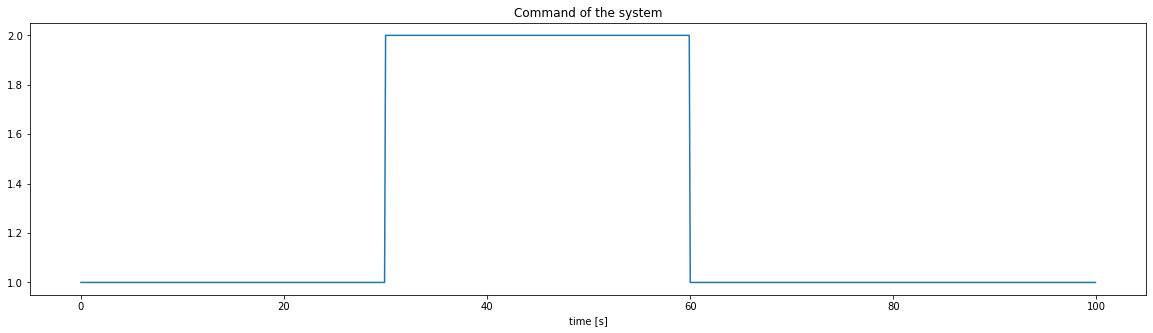

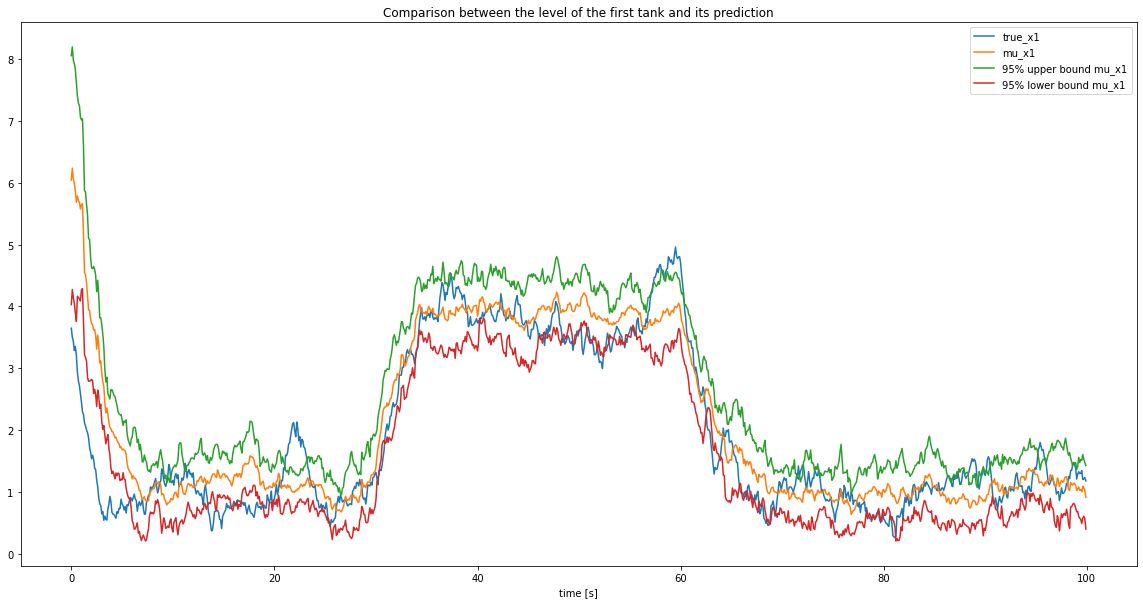

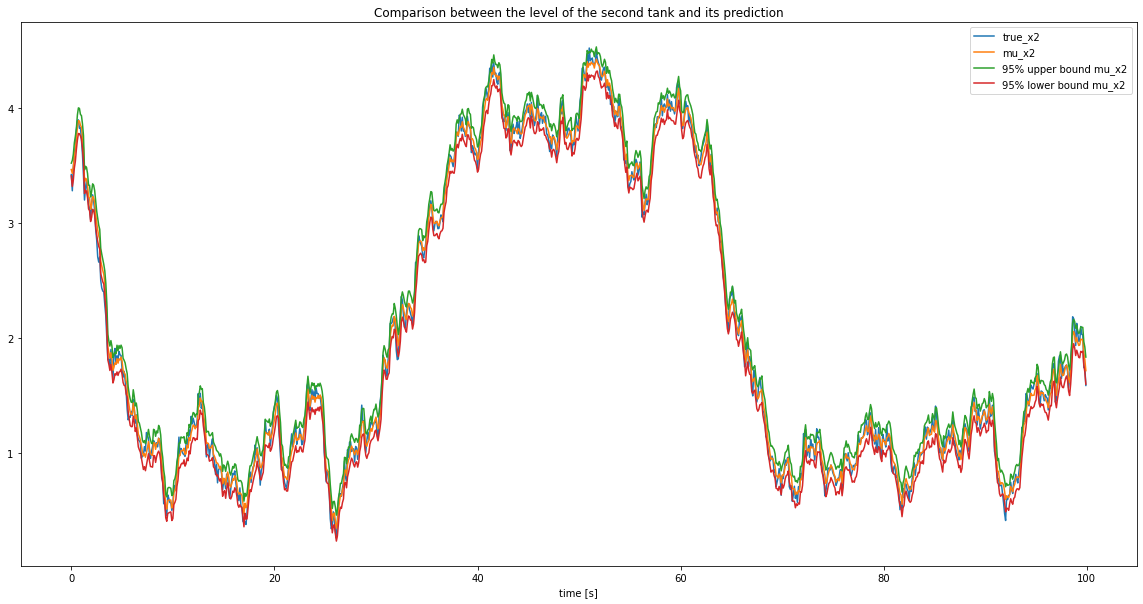

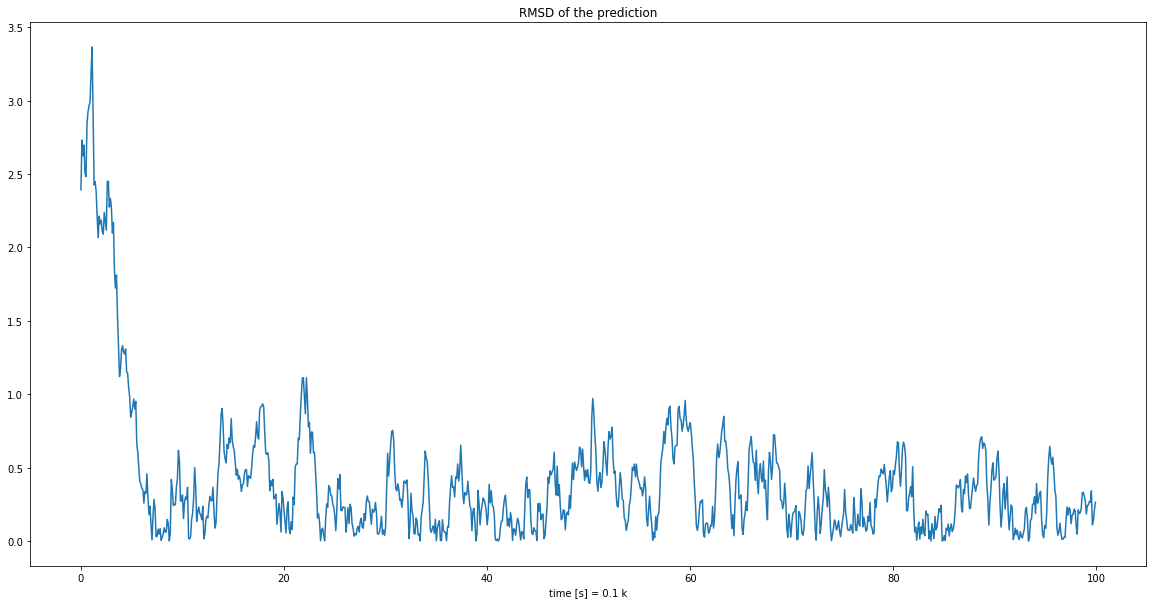

In [11]:
plt.figure(figsize=(20,5))
plt.title("Command of the system")
plt.plot(time, u)
plt.xlabel("time [s]")
plt.show()

sigma_x1 = P["x1x1"].pow(1./2)
sigma_x2 = P["x2x2"].pow(1./2)

plt.figure(figsize=(20,10))
plt.title("Comparison between the level of the first tank and its prediction")
plt.plot(time, true_x1)
plt.plot(time, mu["mu_x1"])
plt.plot(time, mu["mu_x1"] + 1.96 * sigma_x1)
plt.plot(time, mu["mu_x1"] - 1.96 * sigma_x1)
plt.legend(["true_x1", "mu_x1", "95% upper bound mu_x1", "95% lower bound mu_x1"])
plt.xlabel("time [s]")
plt.show()

plt.figure(figsize=(20,10))
plt.title("Comparison between the level of the second tank and its prediction")
plt.plot(time, true_x2)
plt.plot(time, mu["mu_x2"])
plt.plot(time, mu["mu_x2"] + 1.96 * sigma_x2)
plt.plot(time, mu["mu_x2"] - 1.96 * sigma_x2)
plt.legend(["true_x2", "mu_x2", "95% upper bound mu_x2", "95% lower bound mu_x2"])
plt.xlabel("time [s]")
plt.show()

error_x1 = (true_x1 - mu["mu_x1"]).pow(2)
error_x2 = (true_x1 - mu["mu_x1"]).pow(2)

RMSD = np.sqrt((error_x1 + error_x2) / 2)

plt.figure(figsize=(20,10))
plt.title("RMSD of the prediction")
plt.plot(time, RMSD)
plt.xlabel("time [s] = 0.1 k")
plt.show()